In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages

from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# 20180928

# Read in Beacon Data 

In [3]:
df = sd.get_df(sd.dir_path + sd.csv_filenames[1])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [4]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


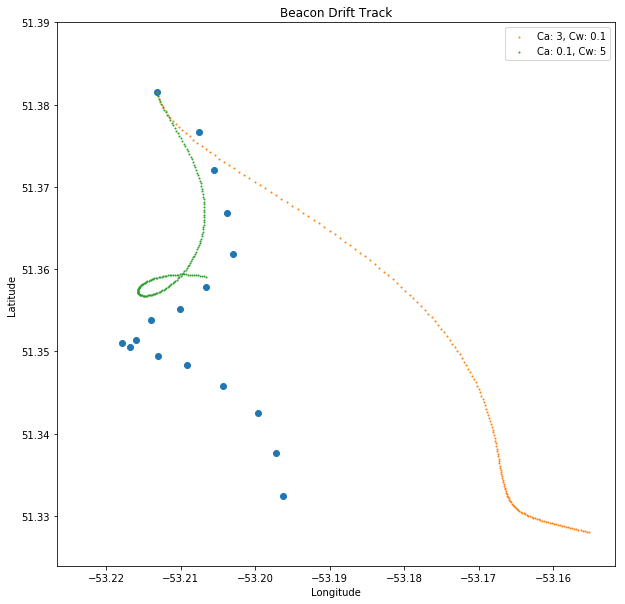

In [5]:
plt.scatter(tc.ref_lons, tc.ref_lats)

sim = simulator.Simulator()

sim.start_latitude = start_latitude
sim.start_longitude = start_longitude
sim.start_time = start_time
sim.end_time = end_time

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(store_results_as=label, **run_sim_kwargs)
plt.scatter(results['longitude'], results['latitude'], s=1, label=label)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(store_results_as=label, **run_sim_kwargs)
plt.scatter(results['longitude'], results['latitude'], s=1, label=label)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()


In [6]:
data = pd.read_csv('debug.log', names=['Fax', 'Fay', 'Fwx', 'Fwy', 'Fcx', 'Fcy', 'Fwpx', 'Fwpy'])

In [7]:
len(data)

179

In [8]:
ds = sim.results['Ca: 0.1, Cw: 5']

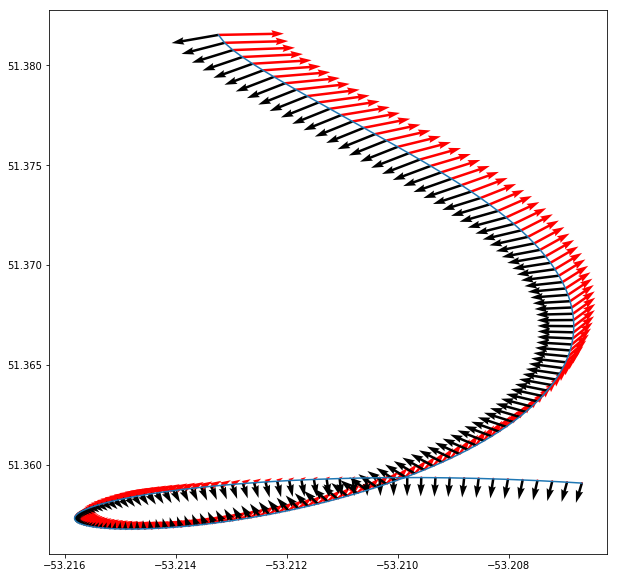

In [9]:
plt.plot(ds['longitude'], ds['latitude'])
plt.quiver(ds['longitude'], ds['latitude'], data['Fax'], data['Fay'], color='red')
plt.quiver(ds['longitude'], ds['latitude'], data['Fcx'], data['Fcy'])

## Plot stereographically

In [41]:
my_plot = plot.Plot()

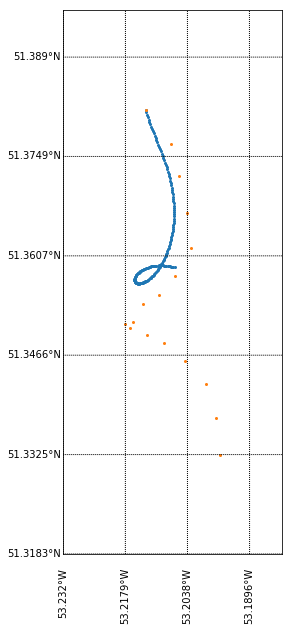

In [30]:
my_plot.plot_track(
    [results['latitude'].values, results['longitude'].values], 
    [tc.ref_lats.values, tc.ref_lons.values],
    s=4
)

# Optimization

In [49]:
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [51]:
keys = ['Ca', 'Cw']
x0 = [1, 1]
bounds = [[1, 10], [1,10]]
reference_vectors = [tc.ref_lats, tc.ref_lons]

sim = simulator.Simulator()
sim.start_latitude = start_latitude
sim.start_longitude = start_longitude
sim.start_time = start_time
sim.end_time = end_time

optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

In [52]:
optimization_result

      fun: 0.008472958905718028
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00062478, -0.00010841])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([ 1., 10.])

## Simulation with Optimization Result

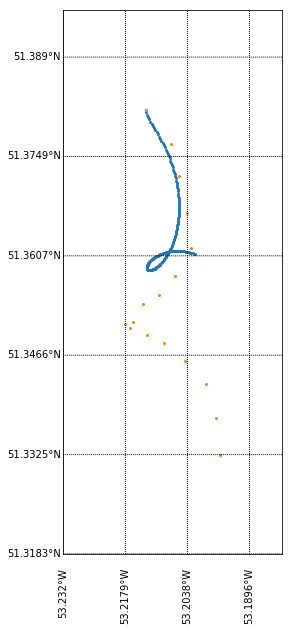

In [53]:
Ca, Cw = optimization_result.x

run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(**run_sim_kwargs)

my_plot.plot_track(
    [results['latitude'].values, results['longitude'].values], 
    [ref_berg.history['latitude'], ref_berg.history['longitude']],
    s=4
)

# Surface Optimization

In [55]:
Ca_num = 3
Cw_num = 3
Ca_lower_bound = 1; Ca_upper_bound = 5
Cw_lower_bound = 5; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [56]:
mse_matrix = np.zeros((Ca_num, Cw_num))
keys = ['Ca', 'Cw']
reference_vectors = [tc.ref_lats, tc.ref_lons]

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

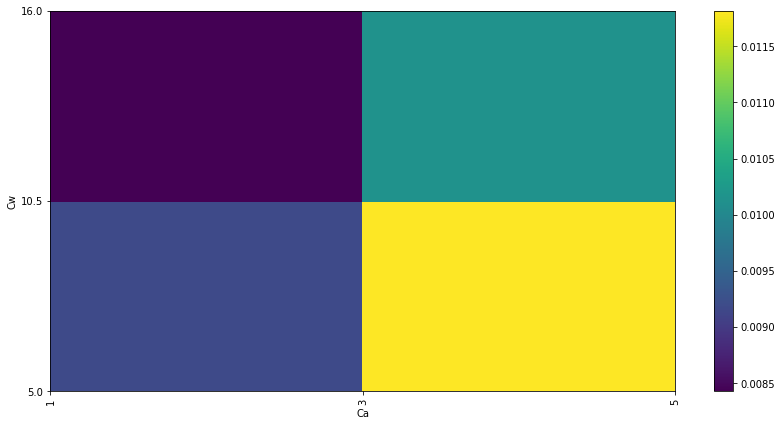

In [57]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)#, vmin=0.02525, vmax=0.02675)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

# 20181011

In [8]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


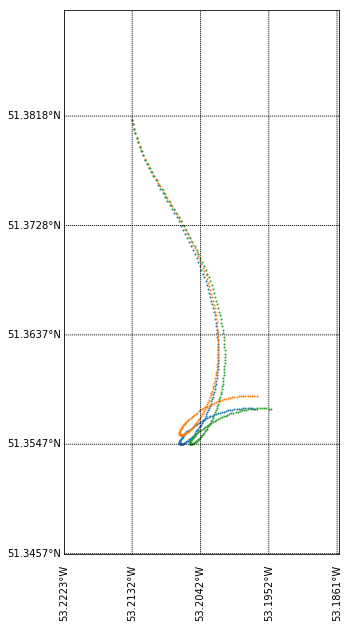

In [39]:
xds = sim.run_simulation(start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False, store_results_as='no_ekman')
xds = sim.run_simulation(start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True, store_results_as='ekman_100')
xds = sim.run_simulation(start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False, 
                         depth_vec=np.arange(0, -1100, -100), store_results_as='ekman_1000')

my_plot.plot_track([sim.results['no_ekman']['latitude'].values, sim.results['ekman']['longitude'].values], 
                   [sim.results['ekman_100']['latitude'].values, sim.results['ekman_100']['longitude'].values], 
                   [sim.results['ekman_1000']['latitude'].values, sim.results['ekman_1000']['longitude'].values])

In [38]:
xds

<xarray.Dataset>
Dimensions:                     (time: 179)
Coordinates:
  * time                        (time) datetime64[ns] 2015-05-06T15:27:39 ...
Data variables:
    latitude                    (time) float64 51.38 51.38 51.38 51.38 51.38 ...
    longitude                   (time) float64 -53.21 -53.21 -53.21 -53.21 ...
    easting                     (time) float64 0.0 7.651 17.26 28.52 41.22 ...
    northing                    (time) float64 0.0 -44.04 -86.78 -128.5 ...
    iceberg_eastward_velocity   (time) float64 0.0255 0.03202 0.03754 ...
    iceberg_northward_velocity  (time) float64 -0.1468 -0.1425 -0.1392 ...

In [62]:
reload(metocean)

<module 'icedef.metocean' from '/home/evankielley/IceDEF/icedef/metocean.py'>

In [57]:
constants = {'eastward_velocity': 1, 'northward_velocity': 2}
ocean = metocean.Ocean((start_time, end_time), constants=constants)

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/xarray/core/computation.py:560: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [36]:
def fill_data_with_constant_value(data, **kwargs):
    for key, value in kwargs.items():
        data[key].values.fill(value)

In [37]:
fill_array_with_constant_value(ocean.data, **)

In [38]:
ocean.current.northward_velocities

<xarray.DataArray (time: 72, latitude: 301, longitude: 301)>
array([[[ 1.078524e+00,  9.057894e-01, ..., -3.314310e-01, -3.253273e-01],
        [ 1.041902e+00,  8.917509e-01, ..., -2.826014e-01, -2.887051e-01],
        ...,
        [ 1.586962e-02,  2.319407e-02, ..., -6.714072e-03, -8.545183e-03],
        [ 1.770074e-02,  1.648000e-02, ...,  6.897183e-02,  5.737480e-02]],

       [[ 1.076083e+00,  9.051790e-01, ..., -3.210547e-01, -3.149510e-01],
        [ 1.035798e+00,  8.868679e-01, ..., -2.722251e-01, -2.795495e-01],
        ...,
        [ 1.953185e-02,  2.624592e-02, ..., -6.103702e-04, -3.051851e-03],
        [ 2.136296e-02,  2.075259e-02, ...,  7.629627e-02,  5.859554e-02]],

       ...,

       [[ 1.182287e+00,  1.218299e+00, ..., -2.380444e-02, -2.197333e-02],
        [ 1.036409e+00,  1.247597e+00, ...,  1.525925e-02,  4.272591e-03],
        ...,
        [-3.051851e-02, -2.807703e-02, ..., -7.324442e-03,  1.220740e-03],
        [-2.685629e-02, -2.502518e-02, ...,  6.103702e-04,